## A standalone example of the Fourier-based prior (Keras/TensorFlow 2)
In this notebook, we will be running a simple example of the Fourier-based prior, in order to show how it can be applied. We will train a very simple model with and without the Fourier-based prior, and at the end we will show the importance scores on a random sample of input sequences using three different methods of computing attributions.

The goal of this notebook is to present a very simple, standalone example of models trained with and without the Fourier-based prior. None of the code in this notebook will rely on libraries/repositories other than very standard and ubiquitous ones (e.g. Keras, NumPy, etc.). Note that this example uses a Keras backend of TensorFlow 2.

We'll be training a simple binary model to predict binding of the SPI1 transcription factor. For the sake of simplicity and efficiency, we'll be training with only one output task (i.e. single-task models), with a slightly simpler data processing. Thus, these results won't fully match those presented in the paper (the results in the paper can be reproduced from the other code/notebooks in this repository).

For more results, see the corresponding paper [here](https://proceedings.neurips.cc/paper/2020/hash/1487987e862c44b91a0296cf3866387e-Abstract.html).

Some of these cells can take awhile to run, and the entire notebook can take on the order of an 30 minutes to complete. Several intermediates are saved along the way, so feel free to run the notebook in pieces, commenting out certain cells that have already been run before.

In [1]:
import keras.models as km
import keras.layers as kl
import keras.optimizers as ko
import keras.backend as kb
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.special
import scipy.stats
import scipy.ndimage
import sklearn.metrics
import pyfaidx
import tqdm
tqdm.tqdm_notebook()

/users/amtseng/miniconda3/envs/att-priors-keras/lib/python3.7/site-packages/ipykernel_launcher.py:15: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  from ipykernel import kernelapp as app


|<bar/>| 0/? [00:00<?, ?it/s]

### Download the data
We'll need the following files to train our model:
1. Locations of SPI1 binding in the human genome (using the hg38 annotation). We will download the called peaks from the [ENCODE project](https://www.encodeproject.org/). Specifically, we'll be fetching the IDR-thresholded optimal peaks (i.e. peaks that the replicates agreed upon the most), using these regions as our positive (binding) set. We will be using the experiment [ENCSR000BGQ](https://www.encodeproject.org/experiments/ENCSR000BGQ/), which measures SPI1 binding in the GM12878 cell line.

2. The hg38 human reference genome. We will be downloading this from the UCSC genome portal.

3. The hg38 chromosome sizes. We will also be downloading this from the UCSC genome portal.

In [2]:
# Make a directory to store everything
!mkdir -p prior_example/data
!mkdir -p prior_example/models
!mkdir -p prior_example/aux_code

In [3]:
# Download the peaks from ENCODE
!wget https://www.encodeproject.org/files/ENCFF071ZMW/@@download/ENCFF071ZMW.bed.gz -O prior_example/data/peaks.bed.gz

--2020-11-17 13:52:20--  https://www.encodeproject.org/files/ENCFF071ZMW/@@download/ENCFF071ZMW.bed.gz
Resolving www.encodeproject.org (www.encodeproject.org)... 34.211.244.144
Connecting to www.encodeproject.org (www.encodeproject.org)|34.211.244.144|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Resolving encode-public.s3.amazonaws.com (encode-public.s3.amazonaws.com)... 52.218.160.10
Connecting to encode-public.s3.amazonaws.com (encode-public.s3.amazonaws.com)|52.218.160.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 733979 (717K) [binary/octet-stream]
Saving to: ‘prior_example/data/peaks.bed.gz’

prior_example/data/ 100%[===================>] 716.78K   993KB/s    in 0.7s    

2020-11-17 13:52:21 (993 KB/s) - ‘prior_example/data/peaks.bed.gz’ saved [733979/733979]



In [4]:
# Download the hg38 reference genome, and unzip it
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz -O prior_example/data/hg38.fasta.gz
!gunzip prior_example/data/hg38.fasta.gz

--2020-11-17 13:52:21--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.fa.gz
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 983659424 (938M) [application/x-gzip]
Saving to: ‘prior_example/data/hg38.fasta.gz’

prior_example/data/ 100%[===================>] 938.09M   109MB/s    in 13s     

2020-11-17 13:52:35 (70.7 MB/s) - ‘prior_example/data/hg38.fasta.gz’ saved [983659424/983659424]



In [5]:
# Download the hg38 chromosome sizes
!wget https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes -O prior_example/data/hg38.chrom.sizes

--2020-11-17 13:53:48--  https://hgdownload.soe.ucsc.edu/goldenPath/hg38/bigZips/hg38.chrom.sizes
Resolving hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)... 128.114.119.163
Connecting to hgdownload.soe.ucsc.edu (hgdownload.soe.ucsc.edu)|128.114.119.163|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11672 (11K) [text/plain]
Saving to: ‘prior_example/data/hg38.chrom.sizes’

prior_example/data/ 100%[===================>]  11.40K  --.-KB/s    in 0s      

2020-11-17 13:53:48 (117 MB/s) - ‘prior_example/data/hg38.chrom.sizes’ saved [11672/11672]



In [6]:
import sys
sys.path.append("prior_example/aux_code/")

In [7]:
peaks_bed_path = "prior_example/data/peaks.bed.gz"
reference_fasta_path = "prior_example/data/hg38.fasta"
chrom_sizes_path = "prior_example/data/hg38.chrom.sizes"

### Prepare the training data
We're going to create a rather simple data loader for our binary dataset. We will split each chromosome into windows of length 1000 bp (i.e. the input sequence length for our models), strided across the chromosome with a stride of 50 bp. A 1000 bp window will be considered a "positive" binding example if the central 200 bp region overlaps a peak summit, and will be considered a "negative" otherwise.

We'll save these labels as big BED files: one for training and one for testing. Our test set will consist of chr1. Our training set will consist of all other canonical (non-scaffold) chromosomes other than chrY and chrM.

In [8]:
# Import the chromosome sizes, ignoring the small scaffolds
chrom_sizes = {}
with open(chrom_sizes_path, "r") as f:
    for line in f:
        chrom, size = line.strip().split()
        if len(chrom) > 5 or chrom in ("chrY", "chrM"):
            continue
        chrom_sizes[chrom] = int(size)

In [9]:
test_chroms = ["chr1"]
train_chroms = [chrom for chrom in chrom_sizes.keys() if chrom not in test_chroms]

In [10]:
# Import the peaks BED
peaks_bed = pd.read_csv(
    peaks_bed_path, sep="\t", header=None,  # Infer compression
    names=[
        "chrom", "peak_start", "peak_end", "name", "score",
        "strand", "signal", "pval", "qval", "summit_offset"
    ]
)
peaks_bed["summit"] = peaks_bed["peak_start"] + peaks_bed["summit_offset"]

In [11]:
input_length = 1000
window_stride = 50
center_overlap_length = 200

In [12]:
train_labels_bed_path = "prior_example/data/train_labels.bed"
test_labels_bed_path = "prior_example/data/test_labels.bed"

In [13]:
def write_chrom_labels(
    chrom, chrom_size, summit_locs, window_length, window_stride,
    window_center_length, labels_bed_fp
):
    """
    For a single chromosome, write its labels a BED file.
    Arguments:
        `chrom`: a single chromosome (e.g. "chr1")
        `chrom_size`: size of the chromosome (e.g. 100000)
        `summit_locs`: an iterable of locations of peak summits
            in this chromosome
        `window_length`: length of windows 
        `labels_bed_fp`: open file pointer of the file to write
            the coordinates and labels
    """
    coord_starts = np.arange(0, chrom_size - window_length, window_stride)
    coord_ends = coord_starts + window_length
    centers = coord_starts + (window_length // 2)
    values = np.zeros_like(coord_starts)
    for summit_loc in summit_locs:
        delta = summit_loc - (window_length // 2)
        values[np.abs(centers - summit_loc) < (window_center_length // 2)] = 1
    for i in tqdm.notebook.trange(len(coord_starts), desc=("Writing " + chrom)):
        labels_bed_fp.write("%s\t%d\t%d\t%d\n" % (chrom, coord_starts[i], coord_ends[i], values[i]))

In [14]:
# Create the label BEDs for each chromosome set

# Clear the files first, if they already exist
with open(train_labels_bed_path, "w") as f:
    pass
with open(test_labels_bed_path, "w") as f:
    pass

# Create the label BEDs
with open(train_labels_bed_path, "a") as f:
    for chrom in sorted(train_chroms):
        summit_locs = peaks_bed[peaks_bed["chrom"] == chrom]["summit"].values
        write_chrom_labels(
            chrom, chrom_sizes[chrom], summit_locs, input_length,
            window_stride, center_overlap_length, f
        )
with open(test_labels_bed_path, "a") as f:
    for chrom in sorted(test_chroms):
        summit_locs = peaks_bed[peaks_bed["chrom"] == chrom]["summit"].values
        write_chrom_labels(
            chrom, chrom_sizes[chrom], summit_locs, input_length,
            window_stride, center_overlap_length, f
        )

In [15]:
def dna_to_one_hot(seqs):
    """
    Converts a list of DNA ("ACGT") sequences to one-hot encodings, where the
    position of 1s is ordered alphabetically by "ACGT". `seqs` must be a list
    of N strings, where every string is the same length L. Returns an N x L x 4
    NumPy array of one-hot encodings, in the same order as the input sequences.
    All bases will be converted to upper-case prior to performing the encoding.
    Any bases that are not "ACGT" will be given an encoding of all 0s.
    """
    seq_len = len(seqs[0])
    assert np.all(np.array([len(s) for s in seqs]) == seq_len)

    # Join all sequences together into one long string, all uppercase
    seq_concat = "".join(seqs).upper()

    one_hot_map = np.identity(5)[:, :-1]

    # Convert string into array of ASCII character codes;
    base_vals = np.frombuffer(bytearray(seq_concat, "utf8"), dtype=np.int8)

    # Anything that's not an A, C, G, or T gets assigned a higher code
    base_vals[~np.isin(base_vals, np.array([65, 67, 71, 84]))] = 85

    # Convert the codes into indices in [0, 4], in ascending order by code
    _, base_inds = np.unique(base_vals, return_inverse=True)

    # Get the one-hot encoding for those indices, and reshape back to separate
    return one_hot_map[base_inds].reshape((len(seqs), seq_len, 4))

def one_hot_to_dna(one_hot):
    """
    Converts a one-hot encoding into a list of DNA ("ACGT") sequences, where the
    position of 1s is ordered alphabetically by "ACGT". `one_hot` must be an
    N x L x 4 array of one-hot encodings. Returns a lits of N "ACGT" strings,
    each of length L, in the same order as the input array. The returned
    sequences will only consist of letters "A", "C", "G", "T", or "N" (all
    upper-case). Any encodings that are all 0s will be translated to "N".
    """
    bases = np.array(["A", "C", "G", "T", "N"])
    # Create N x L array of all 5s
    one_hot_inds = np.tile(one_hot.shape[2], one_hot.shape[:2])

    # Get indices of where the 1s are
    batch_inds, seq_inds, base_inds = np.where(one_hot)

    # In each of the locations in the N x L array, fill in the location of the 1
    one_hot_inds[batch_inds, seq_inds] = base_inds

    # Fetch the corresponding base for each position using indexing
    seq_array = bases[one_hot_inds]
    return ["".join(seq) for seq in seq_array]

In [16]:
# Create a data loader which returns one-hot encoded sequences
# and labels
class BinaryDataLoader:
    def __init__(
        self, labels_npy_path, reference_genome_path, batch_size,
        reverse_complement=True, seed=20200930
    ):
        labels_table = pd.read_csv(
            labels_npy_path, header=None, sep="\t",
            names=["chrom", "start", "end", "value"]
        )
        
        self.coords = labels_table[["chrom", "start", "end"]].values
        labels = labels_table["value"].values
        self.pos_inds = np.where(labels)[0]
        self.neg_inds = np.where(~labels)[0]
        print("Positive coordinates: %d" % len(self.pos_inds))
        print("Negative coordinates: %d" % len(self.neg_inds))
        print("Total: %d" % len(labels))
        
        self.reference_genome_path = reference_genome_path
        
        self.shuffle_rng = np.random.RandomState(seed)
        self.reverse_complement = reverse_complement
        
    def shuffle_data(self):
        self.shuffle_rng.shuffle(self.pos_inds)
        self.shuffle_rng.shuffle(self.neg_inds)
        
    def __len__(self):
        return int(np.ceil(len(self.pos_inds) / batch_size))
    
    def __getitem__(self, index):
        """
        Returns batch of data: a B x L x 4 array of one-hot encoded
        sequences, and a B-array of binary labels.
        """
        batch_slice = slice(index * batch_size, (index + 1) * batch_size)
        pos_coords = self.coords[self.pos_inds[batch_slice]]
        neg_coords = self.coords[self.neg_inds[batch_slice]]
        all_coords = np.concatenate([pos_coords, neg_coords])
        
        labels = np.ones(len(pos_coords) + len(neg_coords))
        labels[len(pos_coords):] = 0
        
        genome_reader = pyfaidx.Fasta(self.reference_genome_path)
        seqs = [
            genome_reader[chrom][start:end].seq for
            chrom, start, end in all_coords
        ]
        one_hot = dna_to_one_hot(seqs)
        
        if not self.reverse_complement:
            return one_hot, labels
        else:
            return np.concatenate([one_hot, np.flip(one_hot, axis=(1, 2))]), \
                np.concatenate([labels, labels])

In [17]:
batch_size = 64
reverse_complement = True
train_data_loader = BinaryDataLoader(
    train_labels_bed_path, reference_fasta_path,
    batch_size, reverse_complement
)
test_data_loader = BinaryDataLoader(
    test_labels_bed_path, reference_fasta_path,
    batch_size, reverse_complement
)

Positive coordinates: 158549
Negative coordinates: 55641291
Total: 55641291
Positive coordinates: 16296
Negative coordinates: 4979109
Total: 4979109


### Define the model
We'll be using the same binary model architecture defined in the paper, except ported to Keras.

In [18]:
def smooth_tensor_1d(input_tensor, smooth_sigma):
    """
    Smooths an input tensor along a dimension using a Gaussian filter.
    Arguments:
        `input_tensor`: a A x B tensor to smooth along the second dimension
        `smooth_sigma`: width of the Gaussian to use for smoothing; this is the
            standard deviation of the Gaussian to use, and the Gaussian will be
            truncated after 1 sigma (i.e. the smoothing window is
            1 + (2 * sigma); sigma of 0 means no smoothing
    Returns an array the same shape as the input tensor, with the dimension of
    `B` smoothed.
    """
    # Generate the kernel
    if smooth_sigma == 0:
        sigma, truncate = 1, 0
    else:
        sigma, truncate = smooth_sigma, 1
    base = np.zeros(1 + (2 * sigma))
    base[sigma] = 1  # Center of window is 1 everywhere else is 0
    kernel = scipy.ndimage.gaussian_filter(base, sigma=sigma, truncate=truncate)
    kernel = kb.constant(kernel)

    # Expand the input and kernel to 3D, with channels of 1
    input_tensor = kb.expand_dims(input_tensor, axis=2)  # Shape: A x B x 1
    kernel = kb.expand_dims(kb.expand_dims(kernel, axis=1), axis=2)  # Shape: (1 + 2s) x 1 x 1

    smoothed = tf.nn.conv1d(
        input_tensor, kernel, stride=1, padding="SAME", data_format="NWC"
    )

    return kb.squeeze(smoothed, axis=2)

In [19]:
def binary_logits_to_probs(logit_pred_vals):
    """
    Converts the model's predicted binary logits into probabilities via a
    sigmoid on all values.
    Arguments:
        `logit_pred_vals`: a tensor/array containing the predicted logits
    Returns a tensor/array of the same shape, containing the predictions as
    raw probabilities by doing a sigmoid. If the input is a tensor, the output
    will be a tensor. If the input is a NumPy array, the output will be a NumPy
    array.
    """
    if type(logit_pred_vals) is np.ndarray:
        return scipy.special.expit(logit_pred_vals)
    else:
        return kb.sigmoid(logit_pred_vals)

In [20]:
def create_binary_predictor():
    """
    Creates an binary TF binding site predictor from a DNA sequence.
    
    The model input is a B x L x 4 tensor, where B is the batch size,
    and L is the sequence length. The output is the LOGITS of each input
    as a B-tensor. Note that the logits are returned in the order
    according to the input sequences.
    """
    input_seq = kl.Input(shape=(input_length, 4), name="input_seq")
    
    # Define the convolutional layers
    depths = [64, 64, 64]
    conv_filter_sizes = [15, 15, 13]
    last_conv_out = input_seq
    for i in range(3):
        last_conv_out = kl.Conv1D(
            filters=conv_filter_sizes[i], kernel_size=conv_filter_sizes[i],
            padding="valid", activation="relu", name=("conv_%d" % (i + 1))
        )(last_conv_out)
        last_conv_out = kl.BatchNormalization(
             momentum=0.1, epsilon=1e-05
        )(last_conv_out)

    # Define the max pooling layer
    pool_out = kl.MaxPooling1D(
        pool_size=40, strides=40, padding="valid"
    )(last_conv_out)
    
    # Flatten the pooling output
    pool_out_flat = kl.Flatten(name="flatten")(pool_out)

    # Define the fully connected layers
    dims = [50, 15]
    last_fc_out = pool_out_flat
    for i in range(2):
        last_fc_out = kl.Dense(
            units=dims[i], activation="relu", name=("dense_%d" % (i + 1))
        )(last_fc_out)
        last_fc_out = kl.BatchNormalization(
             momentum=0.1, epsilon=1e-05
        )(last_fc_out)

    # Map last fully connected layer to final outputs
    output = kl.Dense(
        units=1, name="dense_3"
    )(last_fc_out)
    
    model = km.Model(inputs=input_seq, outputs=output)
    return model


def correctness_loss(true_vals, logit_pred_vals):
    """
    Computes the binary cross-entropy loss.
    Arguments:
        `true_vals`: a B-tensor of true binary values
        `logit_pred_vals`: a B-tensor containing the predicted LOGITS
    Returns a tensor scalar that is the loss for the batch.
    """
    return kb.mean(kb.binary_crossentropy(
        true_vals, logit_pred_vals, from_logits=True
    ))


def fourier_att_prior_loss(
    status, input_grads, freq_limit, limit_softness,
    att_prior_grad_smooth_sigma
):
    """
    Computes an attribution prior loss for some given training examples,
    using a Fourier transform form.
    Arguments:
        `status`: a B-tensor, where B is the batch size; each entry is 1 if
            that example is to be treated as a positive example, and 0
            otherwise
        `input_grads`: a B x L x 4 tensor, where B is the batch size, L is
            the length of the input; this needs to be the gradients of the
            input with respect to the output; this should be
            *gradient times input*
        `freq_limit`: the maximum integer frequency index, k, to consider for
            the loss; this corresponds to a frequency cut-off of pi * k / L;
            k should be less than L / 2
        `limit_softness`: amount to soften the limit by, using a hill
            function; None means no softness
        `att_prior_grad_smooth_sigma`: amount to smooth the gradient before
            computing the loss
    Returns a single scalar Tensor consisting of the attribution loss for
    the batch.
    """
    abs_grads = kb.sum(kb.abs(input_grads), axis=2)

    # Smooth the gradients
    grads_smooth = smooth_tensor_1d(
        abs_grads, att_prior_grad_smooth_sigma
    )

    # Only do the positives
    pos_grads = grads_smooth[status == 1]

    if pos_grads.numpy().size:
        pos_fft = tf.signal.rfft(pos_grads)
        pos_mags = tf.abs(pos_fft)
        pos_mag_sum = kb.sum(pos_mags, axis=1, keepdims=True)
        zero_mask = tf.cast(pos_mag_sum == 0, tf.float32)
        pos_mag_sum = pos_mag_sum + zero_mask  # Keep 0s when the sum is 0  
        pos_mags = pos_mags / pos_mag_sum

        # Cut off DC
        pos_mags = pos_mags[:, 1:]

        # Construct weight vector
        if limit_softness is None:
            weights = tf.sequence_mask(
                [freq_limit], maxlen=tf.shape(pos_mags)[1], dtype=tf.float32
            )
        else:
            weights = tf.sequence_mask(
                [freq_limit], maxlen=tf.shape(pos_mags)[1], dtype=tf.float32
            )
            x = tf.abs(tf.range(
                -freq_limit + 1, tf.shape(pos_mags)[1] - freq_limit + 1, dtype=tf.float32
            ))  # Take absolute value of negatives just to avoid NaN; they'll be removed
            decay = 1 / (1 + tf.pow(x, limit_softness))
            weights = weights + ((1.0 - weights) * decay)

        # Multiply frequency magnitudes by weights
        pos_weighted_mags = pos_mags * weights

        # Add up along frequency axis to get score
        pos_score = tf.reduce_sum(pos_weighted_mags, axis=1)
        pos_loss = 1 - pos_score
        return kb.mean(pos_loss)
    else:
        return kb.constant(0)

In [21]:
def save_model(model, save_path):
    """
    Saves the given model at the given path. This saves the state of the model
    (i.e. trained layers and parameters).
    """
    model.save(save_path)


def restore_model(load_path):
    """
    Restores a model from the given path. It will restore the learned
    parameters to the model.
    """
    custom_objects = {"kb": kb, "tf": tf}
    return km.load_model(load_path, custom_objects=custom_objects)

### Train the models
We'll train two models, one with the Fourier-based prior, and the other without. Note that the first batch might take some time to load, while the reference Fasta is being indexed.

While the model trained without the prior can converge in just 1 - 2 epochs, the model trained with the prior often requires a few more epochs (due to optimizing over multiple objectives). To keep it simple, we'll just train both models for 1 epoch each. This puts the Fourier-based prior at a slight disadvantage in the comparisons, but we will see that the interpretability of the model trained with the prior is still cleaner. We will also verify that the predictive performances between the two models are reasonably close.

In [22]:
learning_rate = 0.001
freq_limit = 150
limit_softness = 0.2
att_prior_grad_smooth_sigma = 3

In [23]:
def train_model(
    data_loader, model, num_epochs, learning_rate, use_prior=False
):
    """
    Trains the model for the given number of epochs.
    """
    optimizer = ko.Adam(lr=learning_rate)
    
    for epoch_i in range(num_epochs):
        losses = []
        t_iter = tqdm.notebook.trange(
            len(data_loader),
            desc=("Epoch %d/%d: Loss: ---" % (epoch_i + 1, num_epochs))
        )
        
        data_loader.shuffle_data()
        for i in t_iter:
            input_seqs, output_vals = data_loader[i]
            
            input_seqs = tf.convert_to_tensor(input_seqs, dtype=tf.float32)
            output_vals = tf.convert_to_tensor(output_vals, dtype=tf.float32)
            
            with tf.GradientTape() as opt_tape:
                with tf.GradientTape() as input_grad_tape:
                    input_grad_tape.watch(input_seqs)
                    logit_pred_vals = model(input_seqs, training=True)

                loss = correctness_loss(
                    output_vals, kb.squeeze(logit_pred_vals, axis=1)
                )
                
                # Compute gradients of the output with respect to the input
                if use_prior:
                    input_grads = input_grad_tape.gradient(
                        logit_pred_vals, input_seqs
                    )
                    input_grads = input_grads * input_seqs  # Gradient * input
                    loss = loss + fourier_att_prior_loss(
                        output_vals, input_grads, freq_limit, limit_softness,
                        att_prior_grad_smooth_sigma
                    )
            
            # Compute gradient and update weights through backprop
            opt_grads = opt_tape.gradient(loss, model.trainable_weights)
            optimizer.apply_gradients(zip(opt_grads, model.trainable_weights))
            
            losses.append(float(loss))
            t_iter.set_description(
                "Epoch %d/%d: Loss: %6.4f" % (epoch_i + 1, num_epochs, float(loss))
            )
        print("Average loss: %6.4f" % np.mean(losses))

In [24]:
def predict_model(data_loader, model):
    """
    Predicts data from the model, and returns the true values
    and the predicted probabilities.
    """
    true_vals, pred_vals = [], []
    
    t_iter = tqdm.notebook.trange(
        len(data_loader), desc="Loss: ---"
    )
    for i in t_iter:
        input_seqs, output_vals = data_loader[i]
        true_vals.append(output_vals)

        input_seqs = tf.convert_to_tensor(input_seqs, dtype=tf.float32)
        output_vals = tf.convert_to_tensor(output_vals, dtype=tf.float32)

        logit_pred_vals = model(input_seqs)
        loss = correctness_loss(
            output_vals, kb.squeeze(logit_pred_vals, axis=1)
        )

        t_iter.set_description("Loss: %6.4f" % float(loss))
        pred_vals.append(
            binary_logits_to_probs(logit_pred_vals.numpy())
        )
    return np.concatenate(true_vals), np.concatenate(pred_vals)

In [25]:
def show_performance(true_vals, pred_vals, acc_thresh=0.5):
    """
    Shows accuracy, auROC, and auPRC.
    """
    pos_mask = true_vals == 1
    neg_mask = true_vals == 0
    
    pos_right = np.sum(pred_vals[pos_mask] > acc_thresh)
    neg_right = np.sum(pred_vals[neg_mask] <= acc_thresh)
    pos_acc = pos_right / np.sum(pos_mask)
    neg_acc = neg_right / np.sum(neg_mask)
    acc = (pos_right + neg_right) / len(true_vals)
    
    auroc = sklearn.metrics.roc_auc_score(true_vals, pred_vals)
    
    precis, recall, thresh = \
        sklearn.metrics.precision_recall_curve(true_vals, pred_vals)
    auprc = sklearn.metrics.auc(recall, precis)
    
    print("Accuracy: %.2f%%" % (acc * 100))
    print("Positive accuracy: %.2f%%" % (pos_acc * 100))
    print("Negative accuracy: %.2f%%" % (neg_acc * 100))
    print("auROC: %.3f" % auroc)
    print("auPRC: %.3f" % auprc)

In [26]:
prior_model_path = "prior_example/models/prior_model.h5"
noprior_model_path = "prior_example/models/noprior_model.h5"

In [27]:
# Instantiate new models
prior_model = create_binary_predictor()
noprior_model = create_binary_predictor()

In [28]:
train_model(
    train_data_loader, prior_model, 1, learning_rate, use_prior=True
)


Average loss: 0.3966


In [29]:
save_model(prior_model, prior_model_path)

In [30]:
train_model(
    train_data_loader, noprior_model, 1, learning_rate, use_prior=False
)


Average loss: 0.2937


In [31]:
save_model(noprior_model, noprior_model_path)

In [32]:
# Load in saved models
prior_model = restore_model(prior_model_path)
noprior_model = restore_model(noprior_model_path)

In [33]:
prior_true_vals, prior_pred_vals = predict_model(test_data_loader, prior_model)
noprior_true_vals, noprior_pred_vals = predict_model(test_data_loader, noprior_model)

In [34]:
# Compare predictive performance
print("Performance with prior")
show_performance(prior_true_vals, prior_pred_vals)
print("")
print("Performance without prior")
show_performance(noprior_true_vals, noprior_pred_vals)

Performance with prior
Accuracy: 88.27%
Positive accuracy: 98.70%
Negative accuracy: 77.86%
auROC: 0.975
auPRC: 0.972

Performance without prior
Accuracy: 91.18%
Positive accuracy: 98.14%
Negative accuracy: 84.23%
auROC: 0.980
auPRC: 0.978


### Compare interpretability
We'll show the importance score tracks for a random sample of the test-set input sequences, to visually confirm the improved signal-to-noise ratio. More sophisticated methods of quantifying the improved interpretability can be found in the other notebooks of this repository (see paper for details).

We will show the importance scores using input gradients and _in silico_ mutagenesis.

At the time of writing this, TensorFlow 2 is not yet supported by [DeepSHAP](https://github.com/slundberg/shap/).

Note that SPI1 binding is a relatively simple task, because of the straightforward motif and binding mode. Although we will see an improvement in the interpretability of models trained with the Fourier-based prior, these improvements are still small compared to the improvements we get when we train on more complex tasks (see the paper for examples of these complex tasks).

We'll also need some code to visualize the importance score tracks.

In [35]:
# Download code for visualizing importance scores
!wget https://raw.githubusercontent.com/amtseng/fourier_attribution_priors/master/src/plot/viz_sequence.py -O prior_example/aux_code/viz_sequence.py

--2020-11-17 14:23:04--  https://raw.githubusercontent.com/amtseng/fourier_attribution_priors/master/src/plot/viz_sequence.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.196.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.196.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7081 (6.9K) [text/plain]
Saving to: ‘prior_example/aux_code/viz_sequence.py’

prior_example/aux_c 100%[===================>]   6.92K  --.-KB/s    in 0s      

2020-11-17 14:23:04 (31.9 MB/s) - ‘prior_example/aux_code/viz_sequence.py’ saved [7081/7081]



In [36]:
import viz_sequence

In [37]:
def interpret_input_grad(model, input_seq):
    """
    Computes input gradient x input for an L x 4 one-hot
    encoded sequence.
    """
    assert input_seq.shape == (input_length, 4)
    input_seq_np = input_seq
    input_seqs = tf.convert_to_tensor([input_seq], dtype=tf.float32)
    with tf.GradientTape() as input_grad_tape:
        input_grad_tape.watch(input_seqs)
        logit_pred_vals = model(input_seqs)

    input_grads = input_grad_tape.gradient(
        logit_pred_vals, input_seqs
    )
    return input_grads.numpy()[0] * input_seq_np

In [38]:
def interpret_ism(model, input_seq):
    """
    Computes in silico mutagenesis for an L x 4 one-hot
    encoded sequence.
    """
    assert input_seq.shape == (input_length, 4)
    mutations = np.tile(input_seq, (len(input_seq) + 1, 1, 1))
    inds = np.arange(len(input_seq))
    mutations[(inds + 1, inds)] = 0  # First one is the original

    mutations = tf.convert_to_tensor(mutations, dtype=tf.float32)
    pred_logits = np.squeeze(model(mutations).numpy(), axis=1)
    return np.expand_dims(pred_logits[0] - pred_logits[1:], axis=1) * input_seq

In [39]:
# Pick a few random positive sequences from the test set
rng = np.random.RandomState(20200930)
rand_inds = rng.choice(test_data_loader.pos_inds, size=5, replace=False)
pos_coords = test_data_loader.coords[rand_inds]

chr1:208342950-208343950
-------------------------------
With prior:
Input gradients


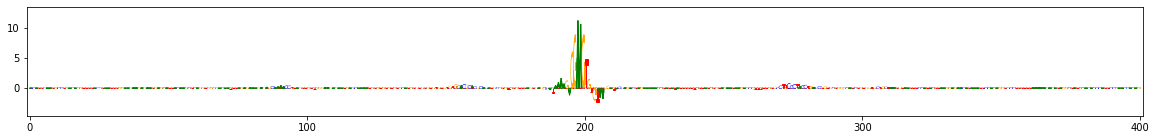

ISM


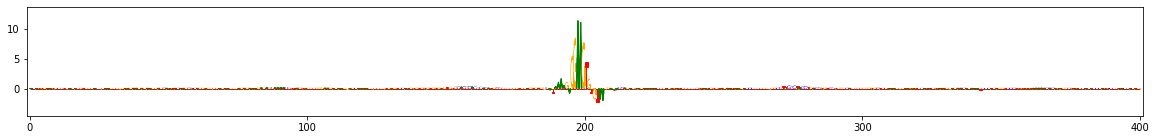

No prior:
Input gradients


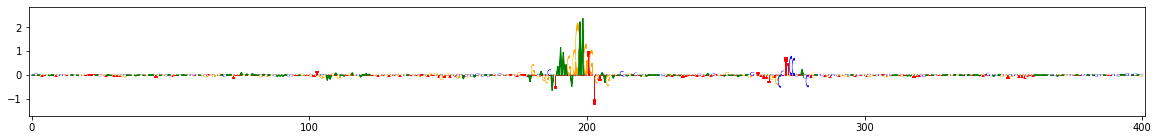

ISM


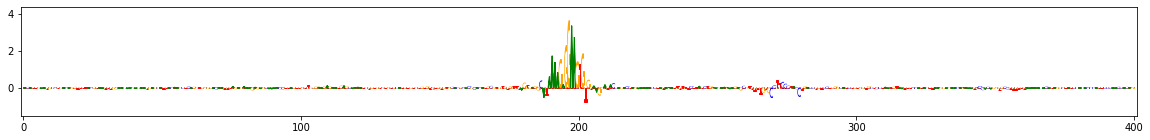

chr1:234880850-234881850
-------------------------------
With prior:
Input gradients


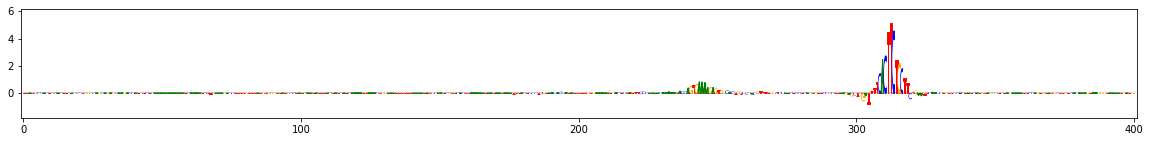

ISM


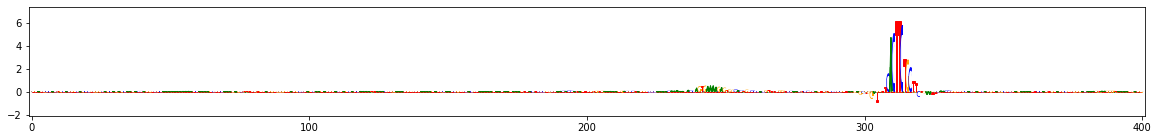

No prior:
Input gradients


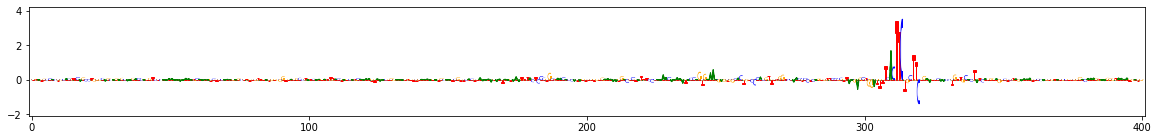

ISM


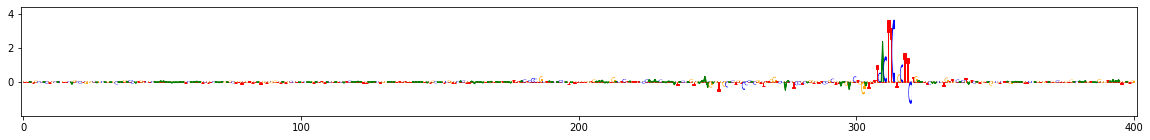

chr1:110259400-110260400
-------------------------------
With prior:
Input gradients


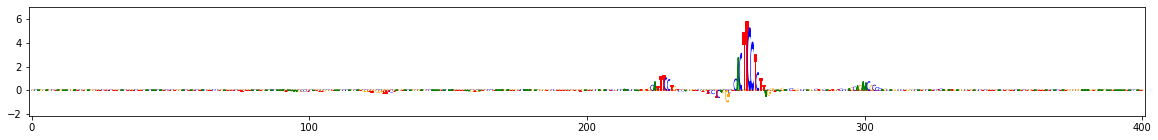

ISM


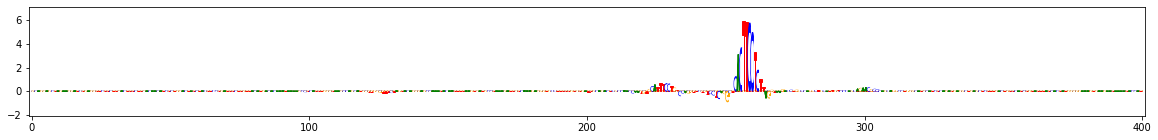

No prior:
Input gradients


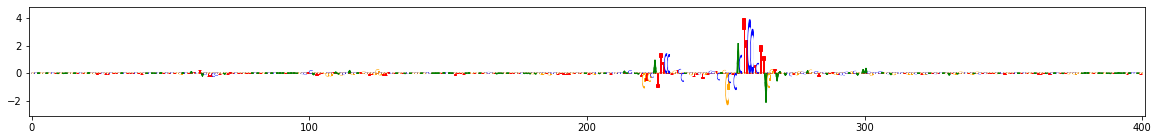

ISM


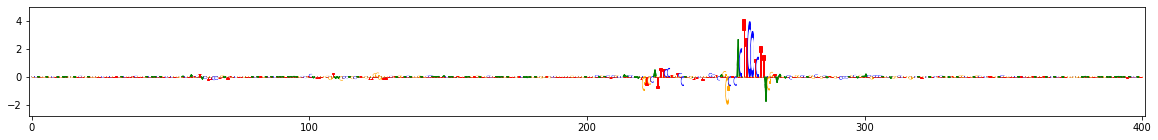

chr1:88647100-88648100
-------------------------------
With prior:
Input gradients


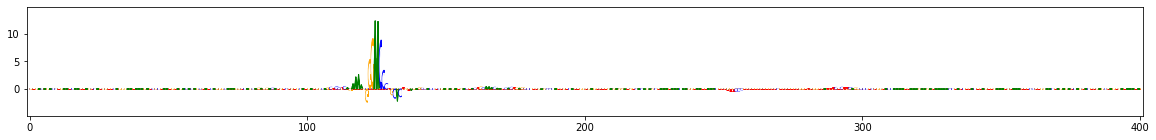

ISM


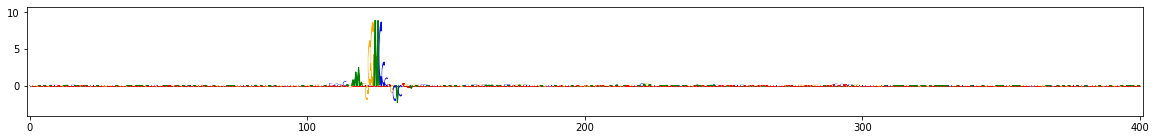

No prior:
Input gradients


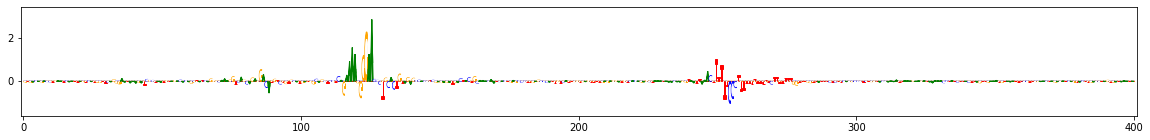

ISM


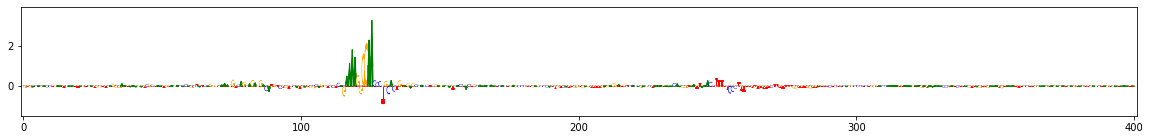

chr1:35506700-35507700
-------------------------------
With prior:
Input gradients


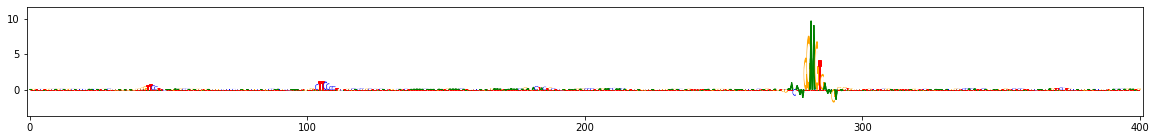

ISM


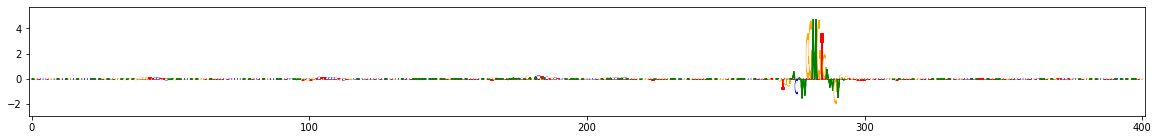

No prior:
Input gradients


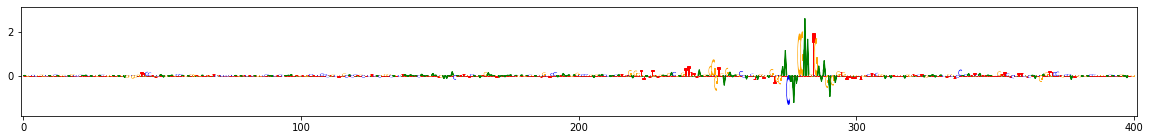

ISM


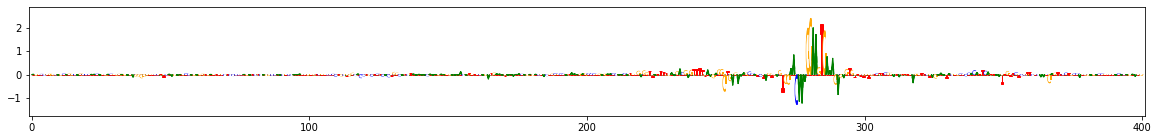

In [40]:
# Show the importance scores
genome_reader = pyfaidx.Fasta(reference_fasta_path)
center_slice = slice(300, 700)
for chrom, start, end in pos_coords:
    print("%s:%d-%d" % (chrom, start, end))
    print("-------------------------------")
    
    input_seq = dna_to_one_hot([genome_reader[chrom][start:end].seq])[0]
    
    print("With prior:")
    print("Input gradients")
    viz_sequence.plot_weights(
        interpret_input_grad(prior_model, input_seq)[center_slice],
        subticks_frequency=100
    )
    print("ISM")
    viz_sequence.plot_weights(
        interpret_ism(prior_model, input_seq)[center_slice],
        subticks_frequency=100
    )
    print("No prior:")
    print("Input gradients")
    viz_sequence.plot_weights(
        interpret_input_grad(noprior_model, input_seq)[center_slice],
        subticks_frequency=100
    )
    print("ISM")
    viz_sequence.plot_weights(
        interpret_ism(noprior_model, input_seq)[center_slice],
        subticks_frequency=100
    )
    print("===============================")